# Capstone Project - The Battle of Neighborhoods

## Data about cities of New York

#### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np

#### Using pandas to create a dataframe from the table available on the Wikipedia page.

In [3]:
data_url = 'https://en.wikipedia.org/wiki/List_of_cities_in_New_York'
table_list = pd.read_html(data_url)

In [4]:
len(table_list) #number of tables obtained from the data url which are converted to pandas dataframes

6

In [5]:
table_list[1] # this is the required dataframe

,City,County,Population [1][2](2010 census),Incorporationdate,FIPS code(subdivision),FIPS code (place)
0,Albany,Albany,97856,1686,3600101000,3601000
1,Amsterdam,Montgomery,18620,1830,3605702066,3602066
2,Auburn,Cayuga,27687,1848,3601103078,3603078
3,Batavia,Genesee,15465,1915,3603704715,3604715
4,Beacon,Dutchess,15541,1913,3602705100,3605100
...,...,...,...,...,...,...
57,Utica,Oneida,62235,1832,3606576540,3676540
58,Watertown,Jefferson,27023,1869,3604578608,3678608
59,Watervliet,Albany,10254,1896,3600178674,3678674
60,White Plains,Westchester,56853,1916,3611981677,3681677


#### Keep only City, County, Population columns

In [6]:
df = table_list[1][['City','County','Population [1][2](2010 census)']]
df = df.rename(columns = {'Population [1][2](2010 census)':'Population'})
df.head()

,City,County,Population
0,Albany,Albany,97856
1,Amsterdam,Montgomery,18620
2,Auburn,Cayuga,27687
3,Batavia,Genesee,15465
4,Beacon,Dutchess,15541


#### Print the shape of the obtained dataframe and check for any nulls

In [7]:
print('Shape of df:', df.shape)
df.isnull().sum()

Shape of df: (62, 3)


City          0
County        0
Population    0
dtype: int64

## Get the geographic coordinates for each city

#### Add a temporary column named 'Address' for the dataframe (df). It helps to find more accurate latitude and longitude locations

In [8]:
state = 'New York'
df['Address'] = df['City'] + ', ' + state
df.head()

,City,County,Population,Address
0,Albany,Albany,97856,"Albany, New York"
1,Amsterdam,Montgomery,18620,"Amsterdam, New York"
2,Auburn,Cayuga,27687,"Auburn, New York"
3,Batavia,Genesee,15465,"Batavia, New York"
4,Beacon,Dutchess,15541,"Beacon, New York"


In [9]:
from geopy.geocoders import Nominatim #use this library to extract the geo coordinates

In [10]:
# We will use apply method of the pandas series to fill in the latitude and longitude values
geolocator = Nominatim(user_agent = 'newyork')

df['geo_coord'] = df['Address'].apply(geolocator.geocode).apply(lambda x : (x.latitude, x.longitude))
df[['Latitude','Longitude']] = df['geo_coord'].apply(pd.Series)
df.drop('geo_coord',axis=1,inplace=True)   #drop this column as we have obtained separate latitude and longitude columns
df

,City,County,Population,Address,Latitude,Longitude
0,Albany,Albany,97856,"Albany, New York",42.651167,-73.754968
1,Amsterdam,Montgomery,18620,"Amsterdam, New York",42.953685,-74.219581
2,Auburn,Cayuga,27687,"Auburn, New York",42.932020,-76.567203
3,Batavia,Genesee,15465,"Batavia, New York",42.998014,-78.187551
4,Beacon,Dutchess,15541,"Beacon, New York",41.504879,-73.969682
...,...,...,...,...,...,...
57,Utica,Oneida,62235,"Utica, New York",43.100903,-75.232664
58,Watertown,Jefferson,27023,"Watertown, New York",43.974784,-75.910757
59,Watervliet,Albany,10254,"Watervliet, New York",42.730078,-73.701230
60,White Plains,Westchester,56853,"White Plains, New York",41.033986,-73.762910


#### Remove the 'Address' column

In [11]:
df.drop('Address',axis=1, inplace = True)
df.head()

,City,County,Population,Latitude,Longitude
0,Albany,Albany,97856,42.651167,-73.754968
1,Amsterdam,Montgomery,18620,42.953685,-74.219581
2,Auburn,Cayuga,27687,42.932020,-76.567203
3,Batavia,Genesee,15465,42.998014,-78.187551
4,Beacon,Dutchess,15541,41.504879,-73.969682


## Building clusters of neighborhoods in New York

In [12]:
!pip install folium==0.5.0  #for geomapping

     |████████████████████████████████| 79 kB 8.5 MB/s  eta 0:00:01
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=44a91b602c99262d8b8ea29a6f2aa1ea2a02b8baf43c633b87fb4db40970aa72
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


Import necessary libraries

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### A. Geographical co-ordinates of New York

In [14]:
address = 'New York'
geolocator = Nominatim(user_agent='newyork')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


#### B. Neighborhood Visualization

In [15]:
# create map of newyork using latitude and longitude 
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=6)

# add markers to the map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['City']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork) 
    
map_newyork

#### C: Using Foursquare API explore the neighborhoods of New York.

Four Square API credentials

In [87]:
# The code was removed by Watson Studio for sharing.

Your four square credentials are received


In [17]:
df.loc[1,'City']

'Amsterdam'

#### D: Show the top venues in Amsterdam within a radius of 30000 meters.

In [18]:
neighborhood_name = df.loc[1,'City'] # neighborhood name
neighborhood_latitude = df.loc[1,'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[1,'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Amsterdam are 42.953685, -74.2195811.


In [19]:
LIMIT = 100
radius = 30000
url = "https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL"

'https://api.foursquare.com/v2/venues/explore?&client_id=FHPTRSATJOVVAX4B1BU3JA0K0XHPKNDQSSFFO5QYWLFU2DUE&client_secret=MU0LYMYBRHA0NJWPSYMOIPPSGAENN4K4EJWMJJLOVQIRJXZE&v=20210113&ll=42.953685,-74.2195811&radius=30000&limit=100'

In [20]:
results = requests.get(url).json()  #obtain the information from foursquare api about venues around 30km radius of Amsterdam

In [21]:
results

{'meta': {'code': 200, 'requestId': '60003e2f73c756627c31a431'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Amsterdam',
  'headerFullLocation': 'Amsterdam',
  'headerLocationGranularity': 'city',
  'totalResults': 148,
  'suggestedBounds': {'ne': {'lat': 43.22368527000027,
    'lng': -73.85136905248203},
   'sw': {'lat': 42.68368472999973, 'lng': -74.58779314751797}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4be60b31cf200f479a25143c',
       'name': "Bosco's Restaurant & Bar",
       'location': {'address': '165 Division St',
        'crossStreet': 'at Bayard St',
        'lat': 42.94511469723591,
        'lng': -74.20073789155079

In [22]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


,name,categories,lat,lng
0,Bosco's Restaurant & Bar,Italian Restaurant,42.945115,-74.200738
1,Recovery Sports Grill,American Restaurant,42.958699,-74.185112
2,Full House Buffet,Chinese Restaurant,42.968892,-74.184887
3,Ruby Tuesday,American Restaurant,42.966054,-74.186193
4,Moe's Southwest Grill,Mexican Restaurant,42.964819,-74.187859


In [24]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [25]:
print ('{} unique categories in Amsterdam.'.format(nearby_venues['categories'].value_counts().shape[0]))

44 unique categories in Amsterdam.


#### E: Exploration of the neighbourhoods in New York.

Now we will generalize the above gathering information about venues to all the cities present in our dataframe.

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=30000, LIMIT=100):
    """
    This function takes the cities names, latitude and longitude locations and send a query to foursquare api for each city.
    Once the results are obtained in json format from the GET request, we will create a new dataframe which contains city's name,latitude,longitude locations
    along with venue's name,category,latitude,longitude locations.    
    
    """
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [27]:
newyork_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Albany
Amsterdam
Auburn
Batavia
Beacon
Binghamton
Buffalo
Canandaigua
Cohoes
Corning
Cortland
Dunkirk
Elmira
Fulton
Geneva
Glen Cove
Glens Falls
Gloversville
Hornell
Hudson
Ithaca
Jamestown
Johnstown
Kingston
Lackawanna
Little Falls
Lockport
Long Beach
Mechanicville
Middletown
Mount Vernon
New Rochelle
New York
Newburgh
Niagara Falls
North Tonawanda
Norwich
Ogdensburg
Olean
Oneida
Oneonta
Oswego
Peekskill
Plattsburgh
Port Jervis
Poughkeepsie
Rensselaer
Rochester
Rome
Rye
Salamanca
Saratoga Springs
Schenectady
Sherrill
Syracuse
Tonawanda
Troy
Utica
Watertown
Watervliet
White Plains
Yonkers


In [34]:
newyork_venues['Venue Category'].value_counts()

American Restaurant                294
Pizza Place                        285
Park                               219
Italian Restaurant                 181
Coffee Shop                        180
Ice Cream Shop                     174
Brewery                            144
Bakery                             143
Bar                                143
Café                               140
Sandwich Place                     136
Grocery Store                      134
Convenience Store                  110
Supermarket                        101
Diner                               96
Trail                               93
Discount Store                      89
Gym                                 87
Mexican Restaurant                  86
Hotel                               81
Restaurant                          78
Deli / Bodega                       74
Pub                                 66
Farmers Market                      64
Donut Shop                          63
Pharmacy                 

In [49]:
newyork_venues = newyork_venues[newyork_venues['Venue Category'] != 'Neighborhood']

In [88]:
print('There are {} unique categories in the dataframe of venues.'.format(len(newyork_venues['Venue Category'].unique())))

There are 293 unique categories in the dataframe of venues.


In [51]:
newyork_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Albany,42.651167,-73.754968,Renaissance Albany Hotel,42.650625,-73.755687,Hotel
1,Albany,42.651167,-73.754968,Iron Gate Cafe,42.655974,-73.762504,Café
2,Albany,42.651167,-73.754968,City Beer Hall,42.649660,-73.754787,Pub
3,Albany,42.651167,-73.754968,Palace Theatre,42.654736,-73.750192,Theater
4,Albany,42.651167,-73.754968,The Olde English Pub & Pantry,42.653958,-73.748563,Pub


#### F: Create a new dataframe which contains the Neighborhood and Number of venues present

In [89]:
newyork_venues_df = newyork_venues.groupby('Neighborhood')['Venue Category'].count().to_frame().reset_index()

In [53]:
newyork_venues_df.columns = ['Neighborhood', 'Number of Venues']
newyork_venues_df.index = np.arange(1, len(newyork_venues_df)+1)
list_rest_no =newyork_venues_df['Number of Venues'].to_list() # we will use this in folium map during clustering if required
list_dist =newyork_venues_df['Neighborhood'].to_list() # we will use this in folium map during clustering if required

In [54]:
newyork_venues_df.head()

,Neighborhood,Number of Venues
1,Albany,100
2,Amsterdam,100
3,Auburn,100
4,Batavia,100
5,Beacon,100


#### G: Create another dataframe using one hot encoding on 'Venue Category' column

In [55]:
# one hot encoding
newyork_onehot = pd.get_dummies(newyork_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
newyork_onehot['Neighborhood'] = newyork_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [newyork_onehot.columns[-1]] + list(newyork_onehot.columns[:-1])
newyork_onehot = newyork_onehot[fixed_columns]

newyork_onehot.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Launch,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Canal,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Gym,College Quad,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Post Office,Pub,RV Park,Racetrack,Ramen Restaurant,Record Shop,Reservoir,Resort,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Ski Lodge,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Water Park,Waterfall,Waterfront,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo

In [57]:
newyork_onehot.shape

(6070, 294)

#### H: Frequency of various venues in each neighborhood¶

In [58]:
# H: Grouping by neighbourhoods and showing the mean of the frequency of occurrence for each category of venues.
newyork_grouped = newyork_onehot.groupby('Neighborhood').mean().reset_index()
newyork_grouped

,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bike Trail,Bistro,Boat Launch,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Burger Joint,Burrito Place,Business Service,Butcher,Café,Cajun / Creole Restaurant,Campground,Canal,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Casino,Castle,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Administrative Building,College Gym,College Quad,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drive-in Theater,Eastern European Restaurant,Electronics Store,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Moroccan Restaurant,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,National Park,Nature Preserve,New American Restaurant,Nightclub,Noodle House,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Polish Restaurant,Pool,Post Office,Pub,RV Park,Racetrack,Ramen Restaurant,Record Shop,Reservoir,Resort,Rest Area,Restaurant,River,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Ski Chalet,Ski Lodge,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,State / Provincial Park,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Water Park,Waterfall,Waterfront,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo

Print the neighbourhoods with their respective top 5 most common venues.

In [60]:
num_top_venues = 5

for hood in newyork_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = newyork_grouped[newyork_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany----
            venue  freq
0     Coffee Shop  0.07
1  Ice Cream Shop  0.06
2   Grocery Store  0.04
3         Brewery  0.04
4             Pub  0.04


----Amsterdam----
                 venue  freq
0    Convenience Store  0.14
1  American Restaurant  0.07
2       Ice Cream Shop  0.05
3   Italian Restaurant  0.05
4                 Farm  0.04


----Auburn----
                 venue  freq
0  American Restaurant  0.09
1           Restaurant  0.06
2                  Bar  0.04
3       Ice Cream Shop  0.04
4                 Café  0.04


----Batavia----
                 venue  freq
0  American Restaurant  0.13
1          Pizza Place  0.07
2       Ice Cream Shop  0.05
3                Diner  0.04
4          Coffee Shop  0.03


----Beacon----
                 venue  freq
0                Trail  0.09
1                  Bar  0.05
2  American Restaurant  0.04
3       Ice Cream Shop  0.04
4         Liquor Store  0.03


----Binghamton----
                 venue  freq
0   Italian Restaurant 

#### We will create a function that takes a row containing neighborhood, along with various venues to give the top most common venues present there.

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now let's see in our neighborhoods what are the top 10 venues

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = newyork_grouped['Neighborhood']

for ind in np.arange(newyork_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(newyork_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany,Coffee Shop,Ice Cream Shop,Grocery Store,Pub,Brewery,Pizza Place,Sandwich Place,Bakery,Burger Joint,American Restaurant
1,Amsterdam,Convenience Store,American Restaurant,Italian Restaurant,Ice Cream Shop,Mexican Restaurant,Restaurant,Pub,Farm,Donut Shop,Pizza Place
2,Auburn,American Restaurant,Restaurant,Café,Ice Cream Shop,Bar,Pub,Park,Pizza Place,Winery,Farm
3,Batavia,American Restaurant,Pizza Place,Ice Cream Shop,Diner,Bar,Deli / Bodega,Donut Shop,Supermarket,Coffee Shop,Department Store
4,Beacon,Trail,Bar,Ice Cream Shop,American Restaurant,Bookstore,Brewery,Liquor Store,Coffee Shop,Bakery,State / Provincial Park
5,Binghamton,American Restaurant,Italian Restaurant,Pizza Place,Bar,Brewery,Diner,Hardware Store,Coffee Shop,Park,Pharmacy
6,Buffalo,Park,Supermarket,Grocery Store,Coffee Shop,Café,American Restaurant,Wine Shop,Pizza Place,Burger Joint,Ice Cream Shop
7,Canandaigua,Ice Cream Shop,Bar,Brewery,Coffee Shop,Pizza Place,Italian Restaurant,Park,Pub,Breakfast Spot,Bakery
8,Cohoes,Coffee Shop,Pizza Place,Grocery Store,Brewery,Pub,Convenience Store,Steakhouse,Ice Cream Shop,Bakery,Mexican Restaurant
9,Corning,American Restaurant,Italian Restaurant,Pizza Place,Park,Ice Cream Shop,Café,Discount Store,Supermarket,Trail,Restaurant


# Clustering

#### We will group our neighborhoods / cities into cluster by using KMeans algorithm

In [64]:
# set number of clusters
kclusters = 5

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 4, 4, 1, 4, 1, 1, 1, 4], dtype=int32)

#### Finding optimal value for K using Elbow method in yellowbrick library

In [65]:
!pip install yellowbrick

     |████████████████████████████████| 269 kB 9.7 MB/s eta 0:00:01


In [66]:
from yellowbrick.cluster import KElbowVisualizer

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


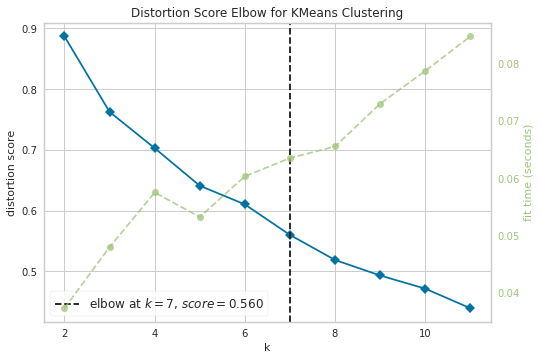

In [67]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(newyork_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


#### Remodelling the kMeans algorithm with k=7 as number of clusters

In [69]:
kclusters = 7

newyork_grouped_clustering = newyork_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(newyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 5, 1, 2, 1, 2, 1, 4, 4, 2], dtype=int32)

#### Add cluster labels to the dataframe neighborhoods_venues_sorted which contains top 10 venues in each neighborhood and create a new dataframe

In [70]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
# add clustering labels to a dataframe
neighborhoods_venues_sorted_w_clusters.insert(0, 'Cluster Labels', kmeans.labels_)

In [71]:
neighborhoods_venues_sorted_w_clusters.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,Albany,Coffee Shop,Ice Cream Shop,Grocery Store,Pub,Brewery,Pizza Place,Sandwich Place,Bakery,Burger Joint,American Restaurant
1,5,Amsterdam,Convenience Store,American Restaurant,Italian Restaurant,Ice Cream Shop,Mexican Restaurant,Restaurant,Pub,Farm,Donut Shop,Pizza Place
2,1,Auburn,American Restaurant,Restaurant,Café,Ice Cream Shop,Bar,Pub,Park,Pizza Place,Winery,Farm
3,2,Batavia,American Restaurant,Pizza Place,Ice Cream Shop,Diner,Bar,Deli / Bodega,Donut Shop,Supermarket,Coffee Shop,Department Store
4,1,Beacon,Trail,Bar,Ice Cream Shop,American Restaurant,Bookstore,Brewery,Liquor Store,Coffee Shop,Bakery,State / Provincial Park


#### We will merge the dataframe neighborhoods_venues_sorted_w_clusters and df to have city,county,population,latitude,longitude columns

In [72]:
newyork_merged = pd.merge(df,neighborhoods_venues_sorted_w_clusters,left_on='City',right_on='Neighborhood')
newyork_merged.drop('Neighborhood',axis=1,inplace=True) # merged dataframe contains 'City', 'Neighborhood' columns.both represents same here. Hence we drop.

In [73]:
newyork_merged.head()

,City,County,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany,Albany,97856,42.651167,-73.754968,4,Coffee Shop,Ice Cream Shop,Grocery Store,Pub,Brewery,Pizza Place,Sandwich Place,Bakery,Burger Joint,American Restaurant
1,Amsterdam,Montgomery,18620,42.953685,-74.219581,5,Convenience Store,American Restaurant,Italian Restaurant,Ice Cream Shop,Mexican Restaurant,Restaurant,Pub,Farm,Donut Shop,Pizza Place
2,Auburn,Cayuga,27687,42.932020,-76.567203,1,American Restaurant,Restaurant,Café,Ice Cream Shop,Bar,Pub,Park,Pizza Place,Winery,Farm
3,Batavia,Genesee,15465,42.998014,-78.187551,2,American Restaurant,Pizza Place,Ice Cream Shop,Diner,Bar,Deli / Bodega,Donut Shop,Supermarket,Coffee Shop,Department Store
4,Beacon,Dutchess,15541,41.504879,-73.969682,1,Trail,Bar,Ice Cream Shop,American Restaurant,Bookstore,Brewery,Liquor Store,Coffee Shop,Bakery,State / Provincial Park


#### Create a map showing the clusters which are formed by the top 10 most common venues in a city.

In [74]:
import folium
import matplotlib

# create a map with folium
map_venues10 = folium.Map(location=[latitude,longitude], zoom_start=7)

# set color scheme for clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(i) for i in colors_array]

#colors = plt.cm.Spectral(np.linspace(0,1,kclusters))

# add markers to the map
for lat, lon, poi, cluster in zip(newyork_merged['Latitude'], 
                                  newyork_merged['Longitude'], 
                                  newyork_merged['City'], 
                                  newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        #radius = list_rest_no[list_dist.index(poi)]*0.5, #the size of the marker is proportional to number of restaurants at that district.
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_venues10)
       
map_venues10



#### Now we isolate the rows into corresponding clusters

## Cluster 0 (park bakery gym)

In [76]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 0,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,Middletown,40.839722,-73.831667,0,Park,Bakery,Gym,Theater,Plaza,Gourmet Shop,Pizza Place,Museum,Cocktail Bar,Gym / Fitness Center
30,Mount Vernon,40.912582,-73.837079,0,Park,Bakery,Gym,Theater,Pizza Place,Museum,Plaza,Gourmet Shop,Butcher,Garden
31,New Rochelle,40.911539,-73.782636,0,Park,Bakery,Gym,Boxing Gym,Theater,Garden,Exhibit,Museum,Art Museum,Pizza Place
32,New York,40.712728,-74.006015,0,Park,Ice Cream Shop,Bookstore,Gourmet Shop,Bakery,Movie Theater,Scenic Lookout,Pier,Cycle Studio,Thai Restaurant
56,Troy,40.740256,-74.005535,0,Park,Gourmet Shop,Bakery,Bookstore,Gym,Art Gallery,Theater,Seafood Restaurant,Taco Place,Scenic Lookout
61,Yonkers,40.931210,-73.898747,0,Park,Bakery,Gym,Theater,Gourmet Shop,Plaza,Museum,Pizza Place,Performing Arts Venue,State / Provincial Park


## Cluster 1 (park, cafe)

In [77]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 1,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Auburn,42.932020,-76.567203,1,American Restaurant,Restaurant,Café,Ice Cream Shop,Bar,Pub,Park,Pizza Place,Winery,Farm
4,Beacon,41.504879,-73.969682,1,Trail,Bar,Ice Cream Shop,American Restaurant,Bookstore,Brewery,Liquor Store,Coffee Shop,Bakery,State / Provincial Park
6,Buffalo,42.886717,-78.878392,1,Park,Supermarket,Grocery Store,Coffee Shop,Café,American Restaurant,Wine Shop,Pizza Place,Burger Joint,Ice Cream Shop
14,Geneva,42.869027,-76.978612,1,Vineyard,Winery,American Restaurant,Bar,Brewery,Café,Ice Cream Shop,Restaurant,Coffee Shop,Pizza Place
19,Hudson,42.252865,-73.790959,1,American Restaurant,Café,Pizza Place,Brewery,Diner,Farm,Restaurant,Trail,Bar,Furniture / Home Store
20,Ithaca,42.439604,-76.496802,1,Ice Cream Shop,American Restaurant,Park,State / Provincial Park,Coffee Shop,Brewery,Sandwich Place,Bakery,Trail,Café
23,Kingston,41.928781,-74.002370,1,Café,American Restaurant,Pizza Place,Coffee Shop,Trail,Ice Cream Shop,Restaurant,Park,Bakery,Cheese Shop
24,Lackawanna,42.819090,-78.833717,1,Supermarket,American Restaurant,Café,Coffee Shop,Ice Cream Shop,Gym,Beer Store,Wine Shop,Park,Grocery Store
26,Lockport,43.168710,-78.696567,1,Park,Coffee Shop,Hot Dog Joint,Café,Mexican Restaurant,Supermarket,Pizza Place,American Restaurant,Wine Shop,Bar
33,Newburgh,41.503427,-74.010418,1,Trail,Bar,American Restaurant,Bookstore,Ice Cream Shop,Brewery,Pizza Place,Liquor Store,Coffee Shop,Bakery


## Cluster 2 (restaurant pizza bar)

In [78]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 2,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Batavia,42.998014,-78.187551,2,American Restaurant,Pizza Place,Ice Cream Shop,Diner,Bar,Deli / Bodega,Donut Shop,Supermarket,Coffee Shop,Department Store
5,Binghamton,42.096968,-75.914341,2,American Restaurant,Italian Restaurant,Pizza Place,Bar,Brewery,Diner,Hardware Store,Coffee Shop,Park,Pharmacy
9,Corning,42.143526,-77.054341,2,American Restaurant,Italian Restaurant,Pizza Place,Park,Ice Cream Shop,Café,Discount Store,Supermarket,Trail,Restaurant
11,Dunkirk,42.479502,-79.333932,2,American Restaurant,Pharmacy,Discount Store,Bar,Ice Cream Shop,Beach,Pizza Place,Convenience Store,Coffee Shop,Liquor Store
12,Elmira,42.089796,-76.807734,2,American Restaurant,Pizza Place,Italian Restaurant,Park,Sandwich Place,Bakery,Discount Store,Supermarket,Coffee Shop,Ice Cream Shop
13,Fulton,43.322846,-76.417159,2,Pizza Place,American Restaurant,Coffee Shop,Supermarket,Bar,Mexican Restaurant,Ice Cream Shop,Italian Restaurant,Café,Park
39,Oneida,43.214405,-75.403915,2,American Restaurant,Pizza Place,Italian Restaurant,Bar,Brewery,Japanese Restaurant,Café,Donut Shop,Farmers Market,Supermarket
40,Oneonta,42.453492,-75.062953,2,Italian Restaurant,American Restaurant,Café,Pizza Place,Brewery,Pharmacy,Bakery,Hotel,Discount Store,Coffee Shop
41,Oswego,43.454728,-76.509597,2,American Restaurant,Pizza Place,Sandwich Place,Bar,Coffee Shop,Donut Shop,Diner,Mexican Restaurant,Ice Cream Shop,Discount Store
43,Plattsburgh,44.692820,-73.455620,2,American Restaurant,Pizza Place,Sandwich Place,Gas Station,Restaurant,Diner,Bagel Shop,Supermarket,Cosmetics Shop,Bar


## Cluster 3 (discountStore sandwich pizza)

In [79]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 3,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Hornell,42.327848,-77.661102,3,Discount Store,Sandwich Place,Pizza Place,Pharmacy,Grocery Store,Bar,Convenience Store,Campground,Café,American Restaurant
36,Norwich,42.531184,-75.523515,3,Discount Store,Pizza Place,Sandwich Place,Grocery Store,Golf Course,Donut Shop,Italian Restaurant,Pharmacy,Post Office,Rest Area
38,Olean,42.077478,-78.429861,3,Sandwich Place,Pizza Place,Discount Store,Bar,Café,American Restaurant,Coffee Shop,Steakhouse,Brewery,Convenience Store


## Cluster 4 (coffee icecream pizza bar pub resta)

In [80]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 4,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany,42.651167,-73.754968,4,Coffee Shop,Ice Cream Shop,Grocery Store,Pub,Brewery,Pizza Place,Sandwich Place,Bakery,Burger Joint,American Restaurant
7,Canandaigua,42.885858,-77.279976,4,Ice Cream Shop,Bar,Brewery,Coffee Shop,Pizza Place,Italian Restaurant,Park,Pub,Breakfast Spot,Bakery
8,Cohoes,42.774245,-73.700119,4,Coffee Shop,Pizza Place,Grocery Store,Brewery,Pub,Convenience Store,Steakhouse,Ice Cream Shop,Bakery,Mexican Restaurant
10,Cortland,42.601181,-76.180484,4,Coffee Shop,Pizza Place,Bar,American Restaurant,Ice Cream Shop,Diner,Ski Area,Liquor Store,Farmers Market,Sports Bar
16,Glens Falls,43.309941,-73.644447,4,American Restaurant,Coffee Shop,Hotel,Convenience Store,Ice Cream Shop,Brewery,Diner,Café,Supermarket,Pizza Place
21,Jamestown,42.097002,-79.235326,4,Coffee Shop,Bar,American Restaurant,Discount Store,Ice Cream Shop,Breakfast Spot,Café,Seafood Restaurant,Sandwich Place,Hotel
28,Mechanicville,42.902855,-73.687341,4,Coffee Shop,American Restaurant,Convenience Store,Pub,Bakery,Hotel,Italian Restaurant,Brewery,Mexican Restaurant,Tea Room
37,Ogdensburg,44.694285,-75.486374,4,Fast Food Restaurant,Coffee Shop,Pizza Place,Grocery Store,Discount Store,Restaurant,Sandwich Place,Pub,Bank,Gas Station
46,Rensselaer,42.642579,-73.742898,4,Coffee Shop,Ice Cream Shop,Pizza Place,Grocery Store,Pub,Brewery,Sandwich Place,Bakery,Burger Joint,Bookstore
47,Rochester,43.157285,-77.615214,4,Park,Pub,Bakery,Coffee Shop,Sandwich Place,Liquor Store,Mexican Restaurant,Café,Brewery,Supermarket


## Cluster 5 (stores, sandwich, restaurant

In [81]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 5,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Amsterdam,42.953685,-74.219581,5,Convenience Store,American Restaurant,Italian Restaurant,Ice Cream Shop,Mexican Restaurant,Restaurant,Pub,Farm,Donut Shop,Pizza Place
17,Gloversville,43.050509,-74.345724,5,Convenience Store,Sandwich Place,American Restaurant,Pharmacy,Pizza Place,Gas Station,Discount Store,Italian Restaurant,Ice Cream Shop,Restaurant
22,Johnstown,43.006869,-74.367644,5,Convenience Store,Sandwich Place,American Restaurant,Discount Store,Pharmacy,Gas Station,Italian Restaurant,Pizza Place,Ice Cream Shop,Supermarket
25,Little Falls,43.043404,-74.859596,5,Discount Store,Italian Restaurant,Gas Station,Convenience Store,American Restaurant,Fast Food Restaurant,Diner,Sandwich Place,Rest Area,Supermarket
58,Watertown,43.974784,-75.910757,5,Italian Restaurant,American Restaurant,Discount Store,Convenience Store,Grocery Store,Sandwich Place,Donut Shop,Pizza Place,Supermarket,Seafood Restaurant


## Cluster 6 (pizza bakery)

In [82]:
newyork_merged.loc[newyork_merged['Cluster Labels'] == 6,newyork_merged.columns[[0] + list(range(3,newyork_merged.shape[1]))]]

,City,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Glen Cove,40.862755,-73.633609,6,Pizza Place,Deli / Bodega,Bakery,Park,Italian Restaurant,Bagel Shop,Boxing Gym,Grocery Store,American Restaurant,Gym / Fitness Center
27,Long Beach,40.588512,-73.657861,6,Beach,Pizza Place,Bakery,Grocery Store,Bagel Shop,Park,Surf Spot,Deli / Bodega,Vegetarian / Vegan Restaurant,Boxing Gym
49,Rye,40.980821,-73.684294,6,Pizza Place,Park,Grocery Store,Italian Restaurant,Trail,American Restaurant,Gym / Fitness Center,Deli / Bodega,State / Provincial Park,Mexican Restaurant
60,White Plains,41.033986,-73.762910,6,Pizza Place,Grocery Store,Park,Italian Restaurant,Trail,Deli / Bodega,State / Provincial Park,Gym / Fitness Center,Brewery,Castle
